## 4. Arrhythmia Detection and Classification

### Imports

In [57]:
import wfdb
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

### Read the data

In [58]:
# --- 0. Load ECG records ---
data_path = '../data'  
record_ids = []
for root, dirs, files in os.walk(data_path):
    for f in files:
        if f.endswith('.dat'):
            record_ids.append(os.path.join(root, f).replace('.dat', ''))

###  Extract Features and Labels from ECG Annotations

features such as:
- RR intervals before and after each beat
- Local heart rate

It also assigns:
- **Label 0** for normal beats (`'N'`)
- **Label 1** for abnormal beats (all others in the valid set)


In [59]:
features = []
labels = []

print("Processing ECG records...")
for record_path in tqdm(record_ids):
    try:
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')

        signal = record.p_signal[:, 0]
        fs = record.fs
        ann_samples = annotation.sample
        ann_symbols = annotation.symbol

        valid_beats = ['N', 'L', 'R', 'A', 'V', 'E', 'F', 'j', 'e']
        for i in range(1, len(ann_samples) - 1):
            sym = ann_symbols[i]
            if sym not in valid_beats:
                continue

            rr_prev = (ann_samples[i] - ann_samples[i - 1]) / fs
            rr_next = (ann_samples[i + 1] - ann_samples[i]) / fs
            local_hr = 60 / rr_prev
            mean_rr = (rr_prev + rr_next) / 2
            hrv = abs(rr_next - rr_prev)  # Heart Rate Variability

            # Label: 0 = Normal, 1 = Abnormal
            label = 0 if sym == 'N' and 60 <= local_hr <= 100 else 1

            features.append([rr_prev, rr_next, local_hr, mean_rr, hrv])
            labels.append(label)

    except Exception as e:
        print(f"Error processing {record_path}: {e}")

print(f"\nTotal beats: {len(features)}")
print(f"Normal beats: {labels.count(0)}, Abnormal beats: {labels.count(1)}")



Processing ECG records...


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 71/71 [00:03<00:00, 18.10it/s]


Total beats: 117218
Normal beats: 60333, Abnormal beats: 56885


In [60]:
# --- 3. Address Class Imbalance (SMOTE) ---
print("\nApplying SMOTE to balance classes...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


Applying SMOTE to balance classes...


### Train-test split

In [61]:
X = np.array(features)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


### Train Classifier

In [62]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

### Evaluation

In [63]:

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_mat)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

fp = np.sum((y_test == 0) & (y_pred == 1))
fn = np.sum((y_test == 1) & (y_pred == 0))

print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}")
print(f"False Positives: {fp}, False Negatives: {fn}")
print("Comment: False positives = Normal ECGs misclassified as arrhythmia.")
print("         False negatives = Arrhythmic ECGs missed by the classifier.")


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.92      0.85     18046
           1       0.90      0.75      0.82     18154

    accuracy                           0.83     36200
   macro avg       0.84      0.83      0.83     36200
weighted avg       0.84      0.83      0.83     36200

Confusion Matrix:
[[16569  1477]
 [ 4542 13612]]
Accuracy: 0.83, Precision: 0.90, Recall: 0.75, F1: 0.82
False Positives: 1477, False Negatives: 4542
Comment: False positives = Normal ECGs misclassified as arrhythmia.
         False negatives = Arrhythmic ECGs missed by the classifier.


### ROC Curve

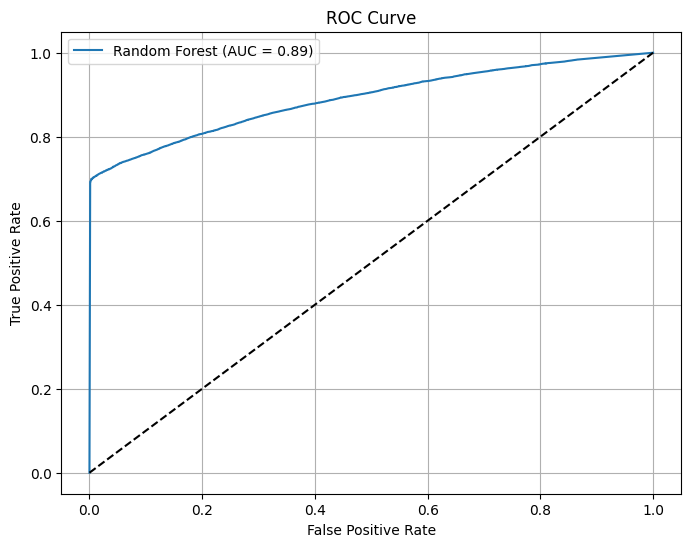

In [64]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()